# Formular la pregunta

### "Cuál es la probabilidad que un tweet que origina dentro de los coordinados geográficos (-78.31, 0.44, -70.71, 11.39) contiene al menos una ocurrencia de la palabra 'yo' con cualquier composición de acentos y letras minúsculas y mayúsculas."

![](http://mediossociales.es/wp-content/uploads/2012/01/twitter_futbol12.jpg)

# Recopilar datos

In [1]:
import os

import tweepy
from tweepy import Stream

from stream_listener import FiniteStreamListener

### Cargar credenciales

In [2]:
CONSUMER_KEY = os.getenv('TWITTER_CONSUMER_KEY_DATA_SCIENCE')
CONSUMER_SECRET = os.getenv('TWITTER_CONSUMER_SECRET_DATA_SCIENCE')
ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN_DATA_SCIENCE')
ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET_DATA_SCIENCE')

In [3]:
COLOMBIA_GEO_LOCATION_BOUNDING_BOX = [-78.31, 0.44, -70.71, 11.39]
NUMBER_OF_TWEETS = 100

In [4]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

### Establecer una conexión al API de Twitter

In [5]:
finite_stream_listener = FiniteStreamListener(number_of_tweets=NUMBER_OF_TWEETS)
streaming_api = Stream(auth=auth, listener=finite_stream_listener)

### Sorber del firehouse

In [9]:
streaming_api.filter(locations=COLOMBIA_GEO_LOCATION_BOUNDING_BOX)

# Limpiar datos

In [10]:
from unidecode import unidecode

### Definir funciones de limpieza

In [11]:
def make_lowercase(tweet):
    return tweet.lower()


def remove_diacritics(tweet):
    return unidecode(tweet)


def remove_non_alpha_characters(tweet):
    return ''.join(character for character in tweet if character.isalpha() or character == ' ')

### Aplicar las funciones

In [12]:
cleaned_tweets = list(finite_stream_listener.tweets)

for cleaning_function in [make_lowercase, remove_diacritics, remove_non_alpha_characters]:
    cleaned_tweets = [cleaning_function(tweet) for tweet in cleaned_tweets]

# Dormir con tus datos

In [13]:
%matplotlib inline

from pprint import pprint
import pandas as pd

In [14]:
KEYWORD = 'yo'

### Primeros 10 tweets

In [17]:
pprint(cleaned_tweets[:10])

['gabriellbarrios va',
 'y sabe como  mil veces mas rico',
 'dejare esto por aca y me retirare muy lentamente httpstcoeqxhqfvo',
 'very modern well organized and clean airport here in bogota',
 'lleguen al dm xd httpstcorxoplhn',
 'muy buen programa felicitaciones sigan asi con temas ocultos  papasmasalla',
 'mostacho siempre me haz dado curiosidad',
 'pusimos en riesgo la vida de la familia al ir a votar por justicia y el '
 'aspecto economico presos mendoza borges g httpstcoazogkhwtn',
 'ojovene emiliojosemend zanozaya rubensca dorletill ktira jhaynsf kaputjan '
 'giselavivenes neguita httpstcoazrxvrsz',
 'deportesee elespectador los ciclistas colombianos son un orgullo  etapas '
 'ganadas este ano en las tres grandes p httpstcoirrcup']


### ¿Cuantas veces aparece la palabra clave?

In [18]:
number_of_occurences = sum(KEYWORD in tweet for tweet in cleaned_tweets)
print('Nuestra palabra clave aparece: {} veces'.format(number_of_occurences))

Nuestra palabra clave aparece: 10 veces


### ¿Con cual frecuencia apareció?

In [19]:
print('Nuestra palabra clave apareció en: {}% de los tweets'.format(100 * number_of_occurences/NUMBER_OF_TWEETS))

Nuestra palabra clave apareció en: 10.0% de los tweets


### ¿Cómo son los tweets que la contienen?

In [20]:
pprint([tweet for tweet in cleaned_tweets if KEYWORD in tweet])

['un hermoso espacio de nuestra bella lauramayolodonde nos cuenta de su amor '
 'por los animales y httpstcoycvdkoqhoj',
 'corrigio los errores del miercoles y partido perfecto gregorio perez leyo '
 'muy bien el juego inteligente en los ca httpstcopunyrbpy',
 'te la dedico amiguis tocayo camilomottar httpstcoqptncd',
 'la vida nos da muchos caminos y yo de pendejo voy por el que dice prohibido '
 'el paso lloraras y sufriras como miserable',
 'yo misma me hago mis regalos y me hago feliz bye',
 'deeply madly in love with you ',
 'yeezoos miercoles  tu yo drama concentrado nothing better',
 'no les intriga saber como reacciona una persona cada vez que lee un mensaje '
 'tuyo a mi si',
 'yo seria feliz con el closet de donna paulsen',
 'merguyovalle jennihian pa que me invitan hajajaja']


### ¿Cuál es la distancia promedia entre ocurrencias consecutivas?

In [21]:
indices_of_tweets_containing_keyword = [index for index, tweet in enumerate(cleaned_tweets) if KEYWORD in tweet]

In [22]:
indices_of_tweets_containing_keyword

[10, 22, 24, 37, 53, 80, 81, 89, 90, 92]

In [23]:
distances_between_indices_of_tweets_containing_keyword = [
    second_index - first_index for first_index, second_index in \
        zip(indices_of_tweets_containing_keyword[:-1], indices_of_tweets_containing_keyword[1:])
]

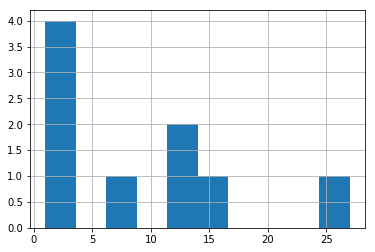

In [24]:
pd.Series(distances_between_indices_of_tweets_containing_keyword).hist()

# Construir un modelo

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta as beta_distribution

### Definir los parámetros de un Beta Distribution

In [26]:
alpha = 1 + number_of_occurences
beta = 1 + (NUMBER_OF_TWEETS - number_of_occurences)

x_values = np.linspace(0, 1, 1002)[1:-1]
pdf_y_values = beta_distribution(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)

### Visualizar

![](http://i.imgur.com/mj059cS.png)

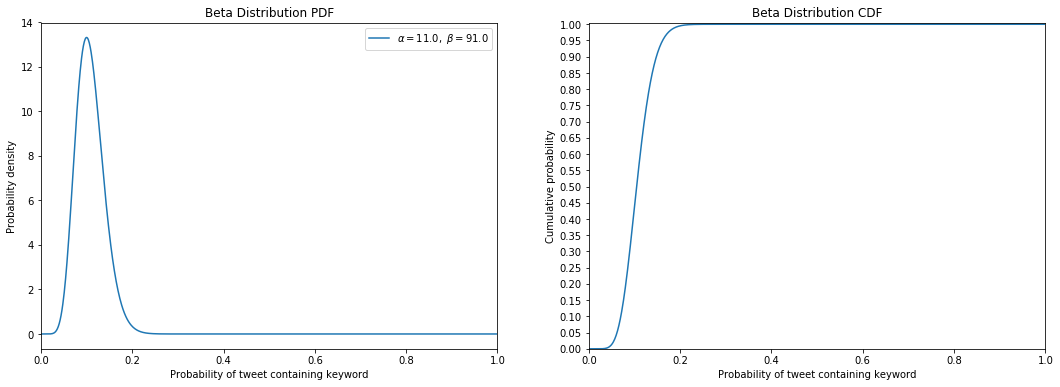

In [27]:
plt.figure(figsize=(18, 6))

# PDF
plt.subplot(121)

plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.1f,\ \beta=%.1f$' % (alpha, beta)))

plt.xlim(0, 1)
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Probability density')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)


# CDF
plt.subplot(122)

plt.plot(x_values, cdf_y_values)

plt.xlim(0, 1)
plt.ylim(0, 1.005)
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Cumulative probability')
plt.title('Beta Distribution CDF')

plt.show()

# Comunicar resultados

### Con 90% de certeza, digamos que la verdadera probabilidad:

In [28]:
fifth_percentile = max(
    [x_value for x_value, y_value in zip(x_values, cdf_y_values) if y_value <= .05]
)

ninety_fifth_percentile = max(
    [x_value for x_value, y_value in zip(x_values, cdf_y_values) if y_value <= .95]
)

In [29]:
print('Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: {} y {}'.format(
    round(fifth_percentile, 4), round(ninety_fifth_percentile, 4)))

Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: 0.0609 y 0.1608


### La probabilidad que la verdadera probabilidad (de que un tweet contiene nuesta palabra clave) sea más grande de .1:

In [30]:
def compute_total_probability_that_probability_less_than_p(p):
    return max(cumulative_prob for cumulative_prob, x_value in zip(cdf_y_values, x_values) if x_value < p)

In [31]:
print('La probabilidad que la verdadera probabilidad es > .1 es: {}'.format(
    1 - compute_total_probability_that_probability_less_than_p(.1))
)

La probabilidad que la verdadera probabilidad es > .1 es: 0.564646851357151
